# 시계열 분석

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_process import arma_generate_sample
from statsmodels.tsa.arima_model import ARMA,ARIMA 
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller,kpss
from statsmodels.stats.diagnostic import acorr_ljungbox,het_goldfeldquandt
from scipy import stats
from scipy.signal import savgol_filter
from statsmodels.tsa.ar_model import AR
import itertools
from sklearn.metrics import r2_score
np.random.seed(123)

## 1. 시계열 자료

- **동일 측정 대상을 여러 시점에서 반복적으로 측정**
- **관측값 사이에 독립성 가정되지 않는다**

### 1) 일변량 시계열 분석

- ARMA, 지수 평활법, 시계열 분해법, 시간을 설명변수로 한 회귀모형 추가, 소매물가지수 등 하나의 변수에 관심을 갖는 경우

### 2) 다중시계열분석

- 계량경제 모형, 전이함수모형, 개입분석, 상태공간 분석, 다변량 ARIMA 등

- 계량경제 : 시계열 데이터에 대한 회귀분석
    - $ER_t = a + B_1IR_t + B_2IF_{t-1}$

### 3) 비정상성 시계열 자료

- 시계열 분석하는데 다루기 어려운 시계열 자료

### 4) 정상성 시계열 자료

- 비정상 시계열을 핸들링해 다루기 쉬운 시계열 자료로 변환
#### ADF Test 이용

- 귀무가설 : 비정상 상태이다. 대립가설 : 정상 상태이다
- pvalue보다 작으면 정상 상태이다.



### 5) 4가지 구성 요소

- 추세 요인 : 형태가 오르거나 내리는 추세를 따르는 경우. 급격한 충격이 없는 한 지속되는 특성.(선형, 이차식, 지수적 형태)


- 순환 요인 : 명백한 경제적 자연적인 이유 없이 알려지지 않은 주기를 가지고 변화(관측기간이 길지 않을 경우 추세 요인과 구분하지 않는다)


- 계절 요인 : 1년의 주기를 가지고 반복되는 변화


- 불규칙 요인 : 일정한 규칙성을 인지할 수 없는 변화 유형

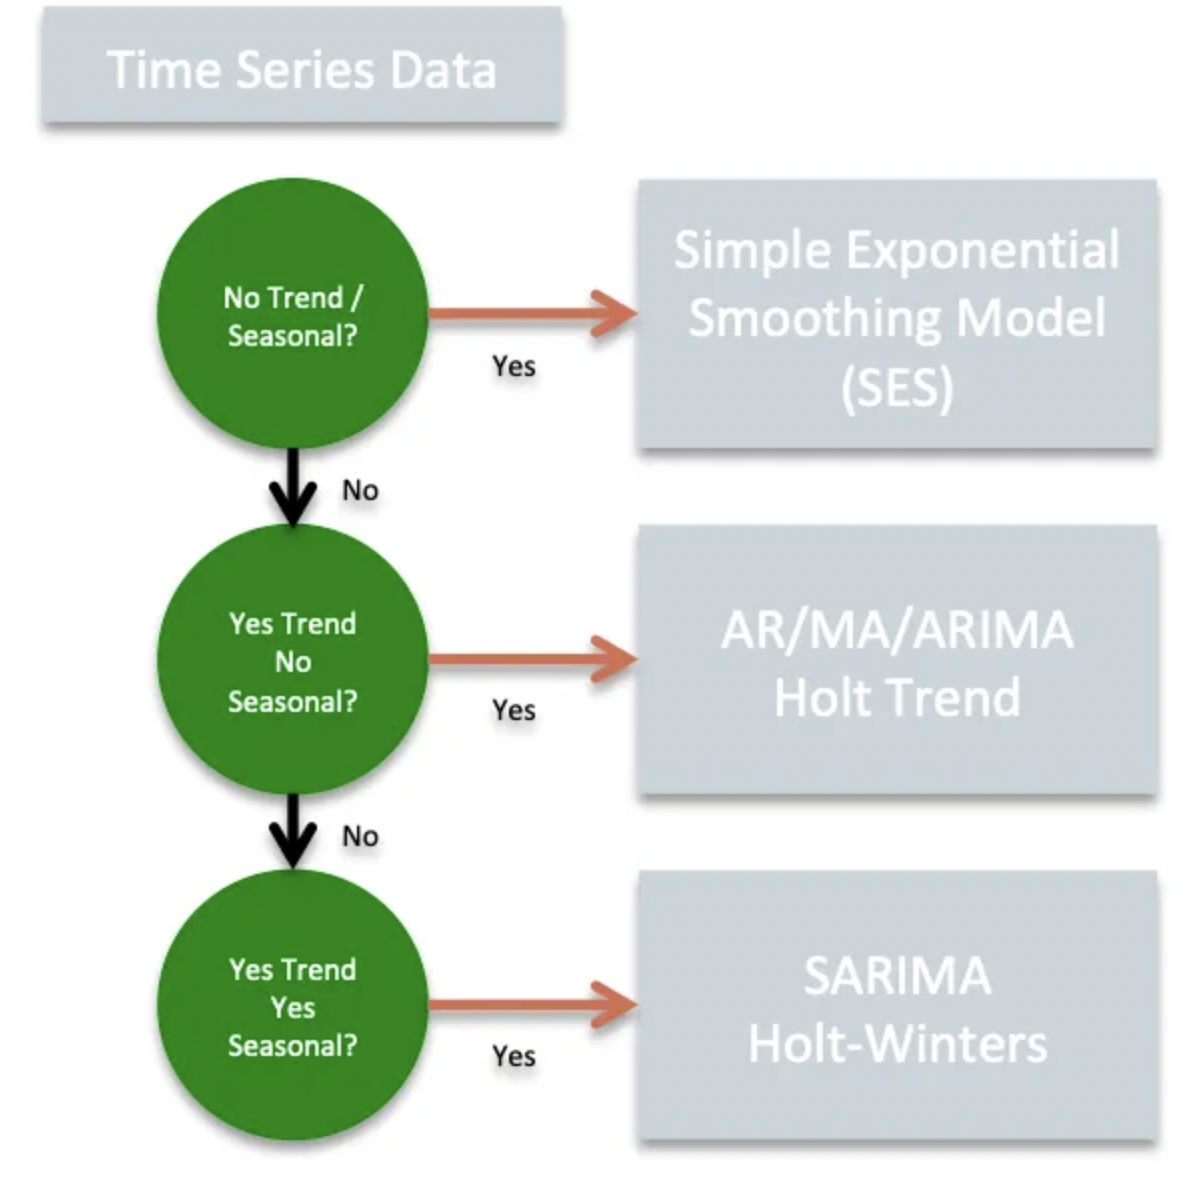

## 2. 시계열 자료 탐색

- 신호(signal) 부분과 잡음(noise) 부분으로 분리하여 분석
- 평활법(Smoothing) & 분해법(Decomposition)

### 1) 시계열 평활

- $x_t = s_t + a_t$
- $s_t : 신호, a_t : 잡음(평균 0,  표준편차 \sigma 인 확률변수 $)

### $smooth_t = \frac{x_{t-k} + ... + x_t + x_{t+k}}{2k + 1}$

- 평활너비가 넓을수록 추정 신호는 평평 + 실제 신호 잡지 못한다.
- 평활너비가 좁을수록 추정 신호의 변동성은 크고, 오신호의 위험 증가

### 2) 계절형 시계열의 분해

- 관측 계열이 1년을 주기로 계절성을 갖는 경우
- ex) 기온, 강수량, 수입, 수출 등
    - $ x_t = T_t + S_t + a_t$
    - $a_t ~ (0,\sigma)$
    - $T_t : 추세(자료가 장기적으로 커지거나 작아지거나 변화가 없거나를 나타내는 요소)$
    - $S_t : 계절성(일정한 주기를 가지고 반복적으로 같은 패턴으로 변화하는 것)$
    - $a_t : 잡음(불규칙하게 변동하는 부분으로 오차 or 잡음)$

In [3]:
samsung = pd.read_csv('samsung.csv')

In [ ]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

In [4]:
moving_list = [5,20,60,120]

for day in moving_list :
    samsung['MA{}'.format(day)] = samsung['close'].rolling(day).mean()

In [5]:
samsung = samsung.set_index(pd.to_datetime(samsung['date'])).iloc[:,1:]

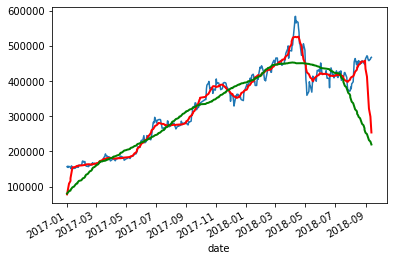

In [8]:
samsung['close'].plot()
plt.plot(samsung.index,smooth(samsung['close'],20),'r-',lw = 2)
plt.plot(samsung.index,smooth(samsung['close'],100),'g-',lw = 2)

In [2]:
unemp = pd.read_csv('unemployment2.csv')

In [3]:
unemp['date'] = pd.to_datetime(unemp['year_month'])

In [4]:
unemp.set_index('date',inplace = True)

In [6]:
def plot_rolling(data, interval):
    
    rolmean = data.rolling(interval).mean()
    rolstd = data.rolling(interval).std()
    
    #Plot rolling statistics:
    plt.figure(figsize=(10, 6))
    plt.xlabel('Date')
    orig = plt.plot(data, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.show()

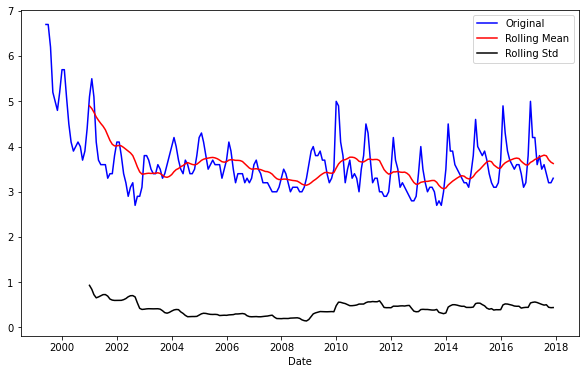

In [7]:
plot_rolling(unemp['unemployment'],20)

- 분산과 평균이 일정한지 파악

- 요인은 seasonal_decompose를 불러와서 확인한다

<Figure size 1296x864 with 0 Axes>

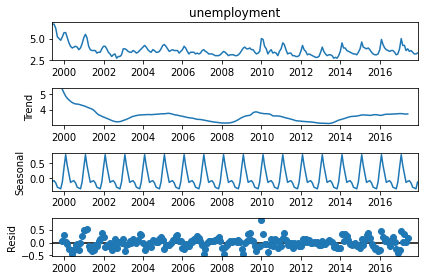

In [44]:
ts = unemp['unemployment']
result = seasonal_decompose(ts,model = 'additive')
plt.figure(figsize = (18,12))
result.plot()
plt.show()

- 위의 Seasonal 그래프를 보고 12개월 단위로 decompose된 것을 볼 수 있다.

- 가법적(additive) 시계열 데이터 : 기초레벨 + 트렌트 + 계절성 + 잔차
- 승법적(multiplicative) 시계열 데이터 : 기초레벨 x 트렌드 x 계절성 x 잔차

- **observed에서 seasonal을 빼면 계절요인을 제거하고 시계열을 분석할 수 있다.**

<AxesSubplot:xlabel='date'>

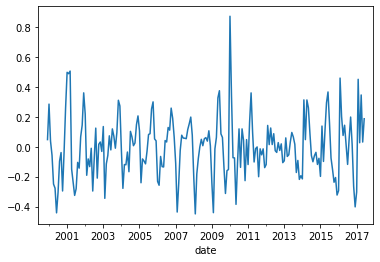

In [46]:
result.resid.plot()

- 잔차가 특정 패턴 없이 무작위 분포를 띠고 작은 값이면 추세와 계절성으로 모형화가 잘 된다. 
- 시계열 자료의 특성을 이해하고 예측하는데 활용가능
- 분해 후 잔차의 특정 패턴(주기적인 파동, 분산이 커지는 등)이 존재하면 잔차에 대해서만 다른 모형을 추가로 적합할 수 있다.

<AxesSubplot:xlabel='date'>

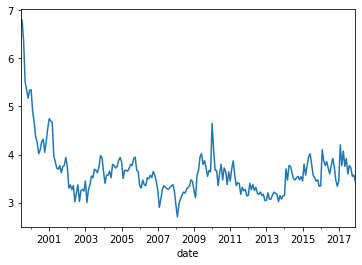

In [49]:
(result.observed - result.seasonal).plot()

- 계절 요인 제거

<AxesSubplot:xlabel='date'>

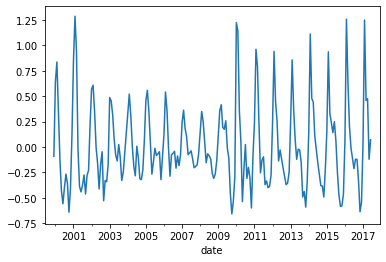

In [57]:
(result.observed - result.trend).plot()

- 추세요인 제거 

평균과 분산이 일정한지 각각 검증

## 3. 정상성 여부 분석

- 평균 일정 x -> 차분

- 분산 일정 x -> 차분 이전에 로그 변환 수행 np.log로 변환 가능

### 3-1 ADF

In [76]:
y = unemp['unemployment']

In [75]:
def adfuller_test(data) :
    result = adfuller(data)
    print("원 데이터의 ADF 값 : {}".format(result[0]))
    print('원 데이터의 P-value : {}\n'.format(result[1]))
    
    result_diff = adfuller(data.diff().dropna())
    print('\n 1차 차분 후 검정')
    print('ADF : {}'.format(result_diff[0]))
    print("ADF P-value : {}".format(result_diff[1]))

- $귀무가설(H_0): 자료에 단위근이 존재한다.$
- $대립가설(H_1): 시계열 자료가 정상성을 만족한다(또는 추세 정상성을 만족한다). 하지만 대립가설은 어떤 방정식을 사용하느냐에 따라 조금씩 다르다.$

In [76]:
adfuller_test(y)

원 데이터의 ADF 값 : -2.3952936246580676
원 데이터의 P-value : 0.14306915688574262



In [ ]:
def adfuller_test(data):
    result = adfuller(data)
    print('Augmented Dickey-Fuller Unit Root Test:')
    labels = ['Test Statistic', 'p-value', 'Number of Lags', 'Number of Obsevations']
    
    for value,label in zip(result,labels):
        print(label+' : '+str(value))
        
    if result[1] <= 0.05:
        print("Reject the null hypothesis. Data has no unit root and is stationary")
    else: 
        print("Time series has a unit root, indicating it is non-stationary")

- p-value가 유의수준보다 크므로 귀무가설을 체택하게 된다. 즉 비정상성이라는 소리
### adfuller(regression = value)

#### value

- 'c' : constant only(default)
- 'ct' : constant and trend
- 'ctt' : constant and linear and quandratic trend
- 'nc' : no constant, no trend

### 3-2 KPSS

In [73]:
def kpss_test(data) :
    statistic, p_value, n_lags, critial_values = kpss(data.values)
    
    print("KPSS Statistic : {}".format(statistic))
    print("P-value : {}".format(p_value))
    print("num_lags : {}".format(n_lags))
    print("Critial_values : {}".format(critial_values))
    
    diff = data.diff().dropna()
    
    statistic_diff, p_value_diff, n_lags_diff, critial_values_diff = kpss(diff.values)
    print("\n 1차 차분 후 검정")
    print("KPSS Statistic : {}".format(statistic_diff))
    print("P-value : {}".format(p_value_diff))
    print("num_lags : {}".format(n_lags_diff))
    print("Critial_values : {}".format(critial_values_diff))

In [74]:
kpss_test(unemp['unemployment'])

KPSS Statistic : 0.47830214044393937
P-value : 0.04655357197208573
num_lags : 15
Critial_values : {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


C:\Users\qhadk\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1661: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)


- KPSS의 경우 유의수준 0.05보다 작기에 귀무가설을 기각한다. 즉, 비정상 시계열이라는 소리

In [ ]:
y1dif = unemp['unemployment'].diff().dropna()
result1 = adfuller(y1dif)
print("1차 차분 데이터의 ADF 값 : {}".format(result1[0]))
print('1차 차분 데이터의 P-value : {}'.format(result1[1]))

### 3-3 ACF & PACF

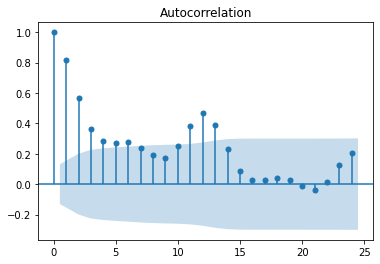

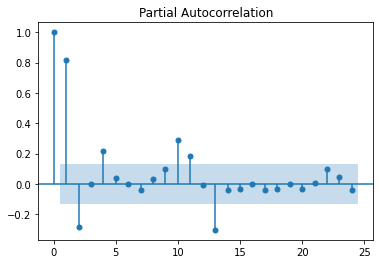

In [69]:
plot_acf(unemp['unemployment'])
plot_pacf(unemp['unemployment'])
plt.show()

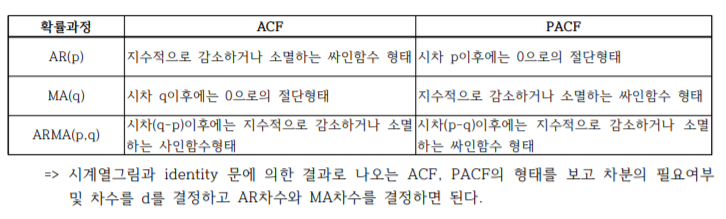

- PACF값이 lag(n)에서 절단점 가지면 AR(n-1)모형
- ACF값이 lag(n)에서 절단점 가지면 MA(n-1)모형

In [77]:
diff_1 = unemp['unemployment'].diff().iloc[1:]

In [79]:
adfuller_test(diff_1)

원 데이터의 ADF 값 : -4.484770016442709
원 데이터의 P-value : 0.00020948270083986424



In [78]:
kpss_test(diff_1)

KPSS Statistic : 0.23628342469503924
P-value : 0.1
num_lags : 15
Critial_values : {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


C:\Users\qhadk\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1661: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
C:\Users\qhadk\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


- adf의 경우는 귀무가설을 기각하고, kpss의 경우에는 귀무가설을 체택하게 된다. 즉 이제 정상성을 만족한다는 소리이다.

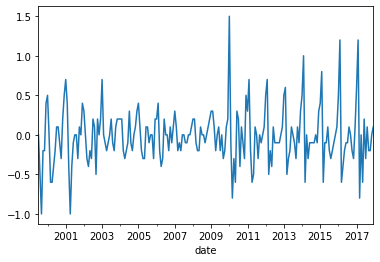

In [82]:
diff_1.plot()
plt.show()

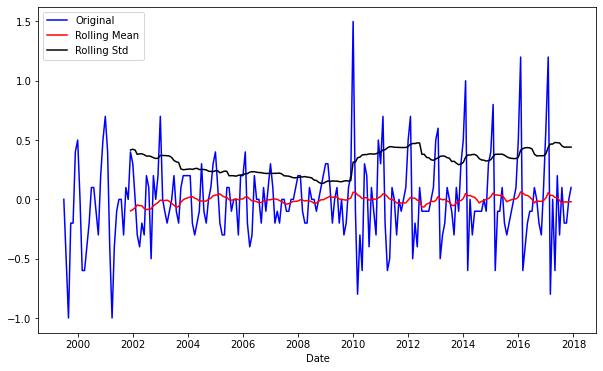

In [83]:
plot_rolling(diff_1,30)

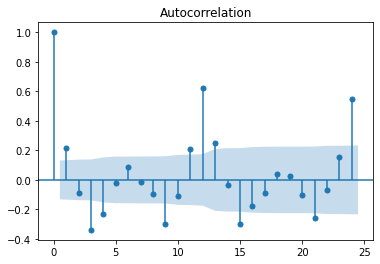

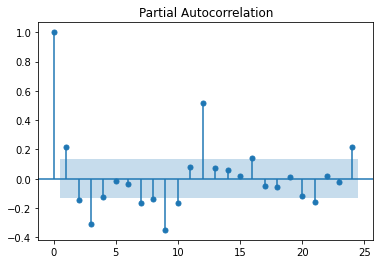

In [80]:
plot_acf(diff_1)
plot_pacf(diff_1)
plt.show()

## 4.모델링

### 4-1 ARIMA(자기회귀누적이동평균모형)

- ARIMA(p,d,q)
- 차분이나 변환을 통해 AR or MA or ARMA로 정상화
- p는 AR, q는 MA모형과 관련있다.
- d = 0 -> ARMA(p,q) 모형이고 정상성 만족
- p = 0 -> IMA(d,q) d번 차분을 통해 MA(q) 모형을 따른다.
- q = 0 -> ARI(p,d) d번 차분을 통해 AR(p) 모형을 따른다.

- trend : constant를 가지고 있는지, c - constant / nc - no constant

- disp : 수렴 정보를 나타냄(정확히 뭐를 나타내는 것인지 모르겠음, 크게 중요한 사항은 아닌듯 함)

In [86]:
model = ARIMA(unemp['unemployment'],order = (0,1,1))
model_fit = model.fit(trend = 'nc',full_output = True, disp = 1)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:         D.unemployment   No. Observations:                  222
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 -70.811
Method:                       css-mle   S.D. of innovations              0.333
Date:                Tue, 25 May 2021   AIC                            145.623
Time:                        15:55:19   BIC                            152.428
Sample:                    07-01-1999   HQIC                           148.370
                         - 12-01-2017                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
ma.L1.D.unemployment     0.2260      0.061      3.726      0.000       0.107       0.345
                                    Roots                                    
                  Real 

C:\Users\qhadk\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\qhadk\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


- 만약 const의 p value 0.05 이상이라면, model.fit()의 파라미터중 trend=’c’가 아니라 ‘nc’로 설정해주어야 하는게 옳다.

In [113]:
aic = []
p = d = q = range(0,3)
pdq = list(itertools.product(p,d,q))
for i in pdq:
    try:
        model = ARIMA(unemp['unemployment'].values, order=(i))
        model_fit = model.fit()
        print(f'ARIMA: {i} >> AIC : {round(model_fit.aic,2)}')
        aic.append(round(model_fit.aic,2))
    except:
        continue

ARIMA: (0, 0, 0) >> AIC : 447.08
ARIMA: (0, 0, 1) >> AIC : 276.49
ARIMA: (0, 0, 2) >> AIC : 183.62
ARIMA: (0, 1, 0) >> AIC : 156.95
ARIMA: (0, 1, 1) >> AIC : 147.32
ARIMA: (0, 1, 2) >> AIC : 148.81
ARIMA: (0, 2, 0) >> AIC : 256.98


C:\Users\qhadk\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA: (0, 2, 1) >> AIC : 163.8
ARIMA: (0, 2, 2) >> AIC : 154.07
ARIMA: (1, 0, 0) >> AIC : 153.63
ARIMA: (1, 0, 1) >> AIC : 137.01
ARIMA: (1, 0, 2) >> AIC : 128.69
ARIMA: (1, 1, 0) >> AIC : 148.53
ARIMA: (1, 1, 1) >> AIC : 152.16
ARIMA: (1, 1, 2) >> AIC : 132.25
ARIMA: (1, 2, 0) >> AIC : 237.42
ARIMA: (2, 0, 0) >> AIC : 133.38
ARIMA: (2, 0, 1) >> AIC : 135.32
ARIMA: (2, 0, 2) >> AIC : 130.63
ARIMA: (2, 1, 0) >> AIC : 145.83
ARIMA: (2, 1, 1) >> AIC : 119.35
ARIMA: (2, 1, 2) >> AIC : 117.89
ARIMA: (2, 2, 0) >> AIC : 234.59


In [114]:
optimal = [(pdq[i], j) for i, j in enumerate(aic) if j== min(aic)]

In [115]:
optimal

[((2, 1, 0), 117.89)]

In [28]:
model = ARIMA(unemp['unemployment'],order = (2,1,0))
model_fit = model.fit(trend = 'nc',full_output = True, disp = 1)

C:\Users\qhadk\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\qhadk\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


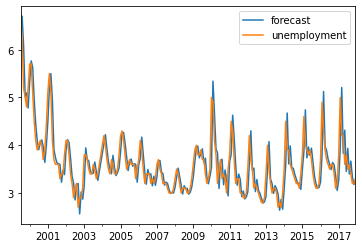

In [29]:
model_fit.plot_predict()
plt.show()

In [30]:
fore = model_fit.forecast(steps=5)
print(fore)

(array([3.32465738, 3.31638381, 3.31080459, 3.31061644, 3.31137085]), array([0.33025411, 0.52778143, 0.65290707, 0.7484633 , 0.83285809]), array([[2.67737122, 3.97194354],
       [2.28195121, 4.35081642],
       [2.03113025, 4.59047893],
       [1.84365533, 4.77757755],
       [1.67899899, 4.94374272]]))


### 4-2 Prophet

- m = Prophet()
- m.fit(data)
- 모델이 데이터의 trend를 잡아내지 못하는 것 같으면 changepoint_prior_scale 파라미터 값을 높여주어 민감하게 감지할 수 있도록 한다.
- m.plot_components()를 통해 주,년 계절성 추세를 알 수 있다.
- seasonality_prior_scale 파라미터로 모델 반영 강도 조절할 수 있다.


- Additive Seasonality : Time series = Trend + Seasonality + Error
- Multiplicative Seasonality : Time series = Trend * Seasonality * Error

In [ ]:
resDiff = sm.tsa.arma_order_select_ic(tra, max_ar=7, max_ma=7, ic='aic', trend='c')
print('ARMA(p,q) =',resDiff['aic_min_order'],'is the best.')

- arma_order_select_ic를 통해 최적의 파라미터를 찾을 수 있다.

## 5. 잔차분석

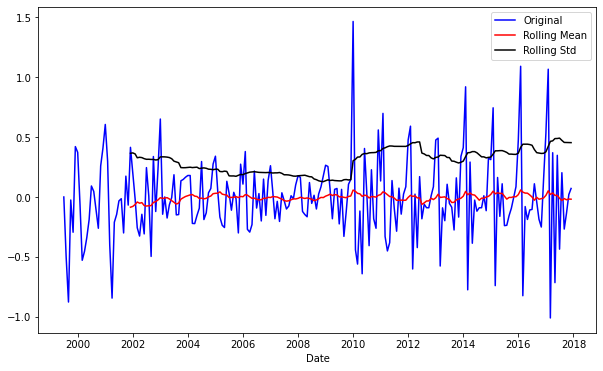

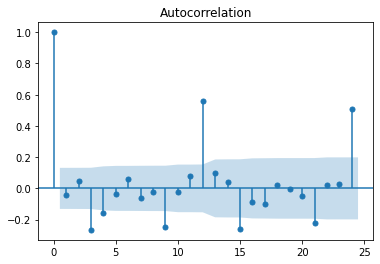

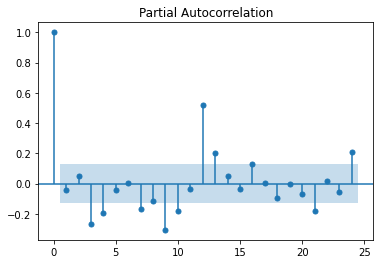

In [31]:
plot_rolling(model_fit.resid, 30)
plot_acf(model_fit.resid)
plot_pacf(model_fit.resid)
plt.show()

### 5.1 정상성

In [77]:
adfuller_test(model_fit.resid)

원 데이터의 ADF 값 : -4.4870839890318805
원 데이터의 P-value : 0.00020748132338129586



### 5.2 정규성

In [33]:
from scipy.stats import probplot
from statsmodels.stats.stattools import durbin_watson
from scipy.stats import shapiro, normaltest

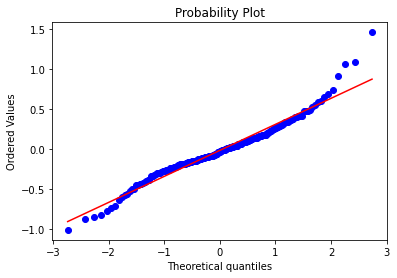

In [34]:
probplot(model_fit.resid,plot=plt)
plt.show()

In [35]:
shapiro(model_fit.resid)

ShapiroResult(statistic=0.9605865478515625, pvalue=8.230547791754361e-06)

- p-value가 0에 가까우므로 귀무가설이 기각되어 정규성에 위반

<AxesSubplot:>

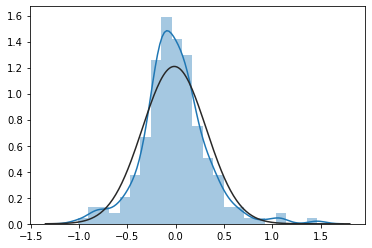

In [74]:
sns.distplot(model_fit.resid,norm_hist="True",fit=stats.norm)

- stats.norm을 이용하여 정규분포와 가까운지 비교

### 5.3 자기상관 테스트

In [36]:
durbin_watson(model_fit.resid)

2.0854860622128606

- 2에 가까울수록 auto correlation을 가지고 있지 않다는 가설을 채택할 수 있다. 지금 값이 2에 가까우므로 가설을 채택한다.

In [103]:
lag_list = [1,5,10,20]
autoco_df = pd.concat([pd.DataFrame(acorr_ljungbox(model_fit.resid,lags = lag_list)[0],columns=['Test-Statistics']),pd.DataFrame(acorr_ljungbox(model_fit.resid,lags = lag_list)[1],columns=['P-value'])],axis = 1).T
autoco_df.columns = ["Autocorr(lag{})".format(i) for i in lag_list]

C:\Users\qhadk\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:524: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


In [104]:
autoco_df

,Autocorr(lag1),Autocorr(lag5),Autocorr(lag10),Autocorr(lag20)
Test-Statistics,0.449416,23.007354,39.437068,1.390427e+02
P-value,0.502612,0.000336,0.000021,7.686664e-20


### 5.4 등분산성

In [62]:
resid_df = pd.DataFrame(model_fit.resid).reset_index()

In [68]:
resid_df.columns = ['date','resid']

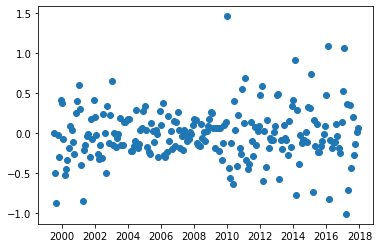

In [71]:
plt.scatter(resid_df['date'],resid_df['resid'])

In [ ]:
het_goldfeldquandt(resid_df['resid'],unemp['unemployment'][1:],alternative='two-sided')

- 귀무가설 : 시계열 데이터가 등분산이다
- 대립가설 : 시계열 데이터가 등분산이 아니다

### 5.5 백색잡음

C:\Users\qhadk\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\regression.py:573: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


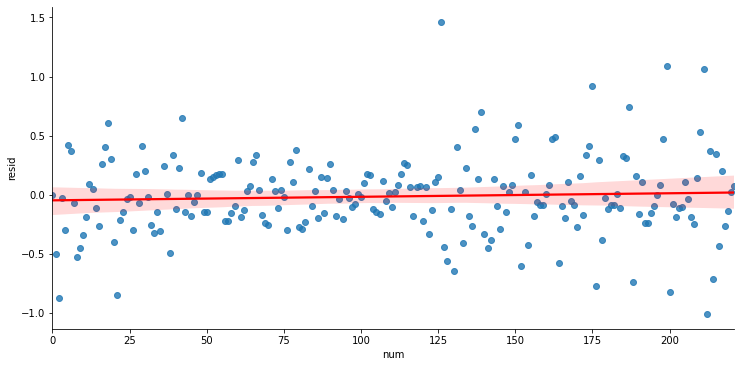

In [91]:
sns.lmplot(data = resid_df,x = 'num',y = 'resid',fit_reg=True,
          line_kws={"color" : "red"}, size = 5.2, aspect=2,ci = 99, sharey=True)

- 추세가 보이지 않으므로 정상시계열이라고 볼 수 있다.

## 6. SARIMA

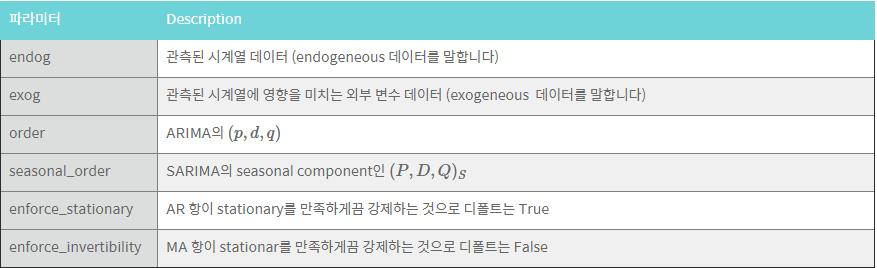

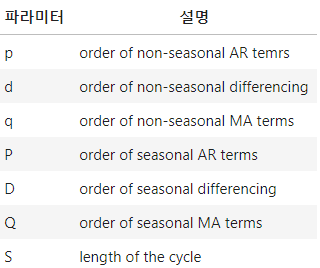

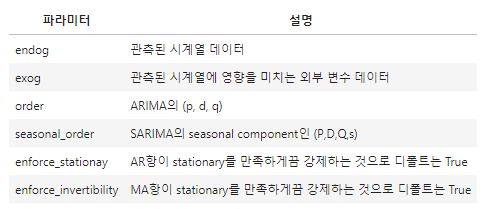

model = sm.tsa.statespace.SARIMAX(df['Travellers'],order=(p,d,q), seasonal_order=(P,D,Q,S))

p는 AR(Auto-Regressive) 파라미터를, 그리고 q는 MA(Moving Average)파라미터를 의미하고 d는 정상성을 찾기위해 몇 번의 lag를 써서 Differencing 해주었는지를 의미하는 파라미터이다. 대문자 P,D,Q는 같은 의미의 파라미터인데 Seasonal Differencing을 통해 찾은 파라미터 값들을 적용하면 되고, S는 우리가 설정한 Seasonality 주기를 의미한다(여기서는 12). 이제 한 lag씩 Differencing 해보면서 적절한 d와 D값을 찾아보도록 하자.

- 기존 ARIMA(p, d, q)에 계절성 주기를 나타내는 차수 s가 필요하며 SARIMA(P, D, Q, s)로 표기한다

In [ ]:
df['Travellers 1st Diff'] = df['Travellers'] - df['Travellers'].shift(1)
df['Travellers 2nd Diff'] = df['Travellers 1st Diff'] - df['Travellers 1st Diff'].shift(1)

#Seasonal Differencing
df['Seasonal Diff'] = df['Travellers'] - df['Travellers'].shift(12)
df['Seasonal 1st Diff'] = df['Travellers 1st Diff'] - df['Travellers 1st Diff'].shift(12)

#1st Differncing adfuller test
adfuller_test(df['Travellers 1st Diff'].dropna())

#1st Seasonal Differencing 
adfuller_test(df['Seasonal 1st Diff'].dropna())

- adfuller test 결과 lag 1 Differencing에서, 또 lag 1 Seasonal Differencing에서 정상성(Stationarity)이 인정된다. 따라서 d=1, D=1로 파라미터 값을 지정할 수 있다.

In [5]:
unemp = unemp[['unemployment']]

In [6]:
p = d = q = range(0, 3)

# Generate all different combinations of p, q and d triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and d triplets
seasonal_pdq = [ (x[0], x[1], x[2], 12)  for x in pdq ]

print('Example of parameter combinations for Seasonal ARIMA ...')
print('SARIMAX:  {} x {}'.format(pdq[1], seasonal_pdq[1]) )
print('SARIMAX:  {} x {}'.format(pdq[1], seasonal_pdq[2]) )
print('SARIMAX:  {} x {}'.format(pdq[2], seasonal_pdq[3]) )
print('SARIMAX:  {} x {}'.format(pdq[2], seasonal_pdq[4]) )

Example of parameter combinations for Seasonal ARIMA ...
SARIMAX:  (0, 0, 1) x (0, 0, 1, 12)
SARIMAX:  (0, 0, 1) x (0, 0, 2, 12)
SARIMAX:  (0, 0, 2) x (0, 1, 0, 12)
SARIMAX:  (0, 0, 2) x (0, 1, 1, 12)


In [ ]:
best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
tmp_model = None
best_mdl = None

for param in pdq :
    for params in seasonal_pdq :
        try :
            tmp_mdl = SARIMAX(unemp['unemployment'],exog=None,
                             order= param,
                             seasonal_order=params,
                             enforce_invertibility=True,
                             enforce_stationarity = True)
            
            res = tmp_mdl.fit()
            print('SARIMAX{} x {}12 - AIC : {}'.format(param,params,res.aic))
            if res.aic < best_aic :
                best_pdq = param
                best_seasonal_pdq = params
                best_mdl = tmp_mdl
        except:
            continue
            
print("Best SARIMAX {} x {}12 model AIC : {}".format(best_pdq,best_seasonal_pdq,best_aic))

In [13]:
sarima_model = SARIMAX(endog=unemp,order = (2,1,0),
       seasonal_order=(1,2,1,12),enforce_invertibility=True,
       enforce_stationarity=True)

sarima_fit = sarima_model.fit()

C:\Users\qhadk\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\qhadk\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [14]:
print(sarima_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                         unemployment   No. Observations:                  223
Model:             SARIMAX(2, 1, 0)x(1, 2, [1], 12)   Log Likelihood                 -10.312
Date:                              Tue, 25 May 2021   AIC                             30.624
Time:                                      21:48:29   BIC                             47.065
Sample:                                  06-01-1999   HQIC                            37.279
                                       - 12-01-2017                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0834      0.065     -1.275      0.202      -0.212       0.045
ar.L2         -0.06

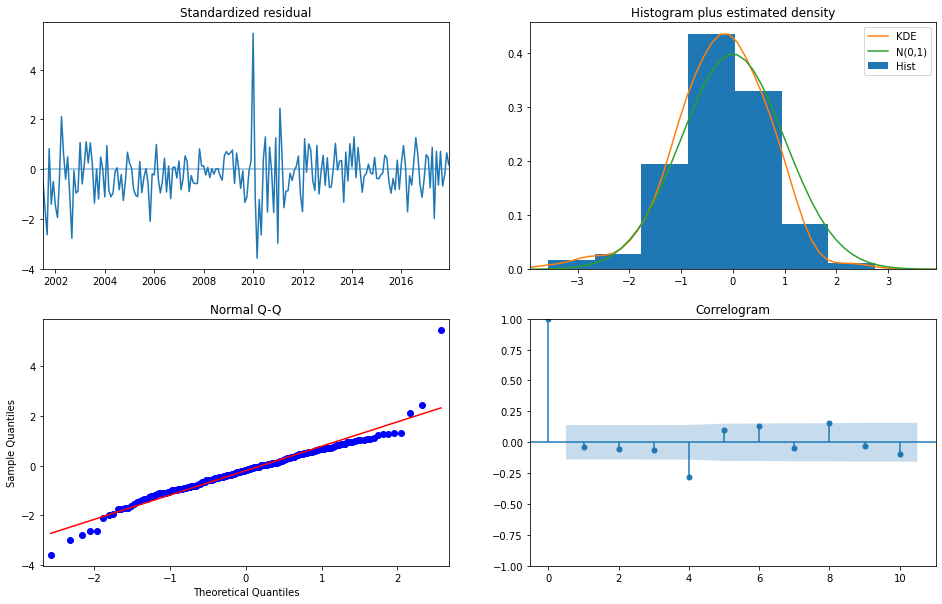

In [16]:
sarima_fit.plot_diagnostics(figsize = (16,10))
plt.show()

In [18]:
pred = sarima_fit.get_prediction(start=pd.to_datetime('2018-01-01'),
                         end = pd.to_datetime('2019-12-01'),dynamic=True)

<AxesSubplot:xlabel='date'>

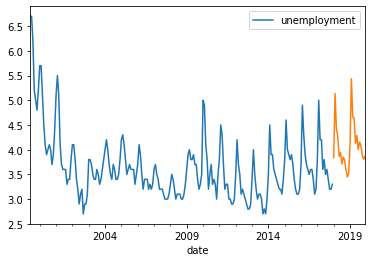

In [27]:
ax = unemp.plot()
pred.predicted_mean.plot(ax = ax)

In [32]:
 pred_uc = sarima_fit.get_forecast(steps=24)

- steps 갯수만큼 예측

In [34]:
pred_forecast = pred_uc.conf_int()

<AxesSubplot:xlabel='date'>

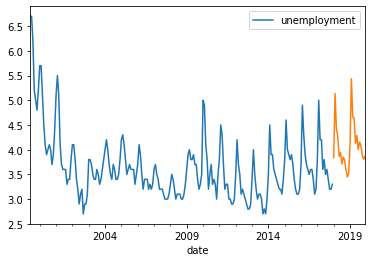

In [38]:
ax = unemp.plot()
pred_uc.predicted_mean.plot(ax = ax)

## 7. 시계열 통계 모델의 장단점

**장점**

- 모델의 파라미터 측면을 보면 명확하게 이해 가능
- 어느 정도 작은 데이터셋에 적용해도 여전히 좋은 결과
- 과적합이라는 위험성 없이도 좋은 성능 얻을 수 있다


**단점**

- 항상 성능 향상 보장하지 않는다. 대규모 데이터셋으로 작업한다면 ML DL 사용하는 것이 낫다.
- 분포보다 분포의 평균값 추정에 집중한다. 
- 비선형 관계가 많은 데이터를 설명하는데 적합하지 않다.

## 8. 평활기법

### 8.1 이동평균(MA)

- **중심이동평균**
- 특정시점에서 과거와 미래의 각각 동일한 개수의 데이터를 평균하여 계산 -> 미래의 데이터를 사용해야하는 중심이동평균은 예측목적으로 사용될 수 없다.
- 계절성을 갖는 시계열에서 윈도우의 폭을 결정하는 방법 : 추세를 더 잘 시각화할 수 있도록 계절을 없애는 방식으로 윈도우의 폭을 계절주기의 길이로 선택(예를 들어 연간계절성을 갖는 데이터의 경우 w = 12를 선택)


- **후행이동평균**
- 데이터 분석의 목적이 예측인 경우에 후행이동평균 사용, 윈도우의 폭은 시계열의 가장 최근의 사용가능한 w개의 값들이 선택되도록 정해진다.

In [49]:
unemp = pd.read_csv('unemployment2.csv')

In [52]:
unemp['year_month'] = pd.to_datetime(unemp['year_month'])
unemp.set_index("year_month",inplace = True)

In [57]:
unemp['unemployment'].rolling(window = 5).mean()

year_month
1999-06-01     NaN
1999-07-01     NaN
1999-08-01     NaN
1999-09-01     NaN
1999-10-01    5.96
              ... 
2017-08-01    3.74
2017-09-01    3.58
2017-10-01    3.50
2017-11-01    3.38
2017-12-01    3.34
Name: unemployment, Length: 223, dtype: float64

In [60]:
unemp['unemployment'].rolling(window = 6, center = True).mean()

year_month
1999-06-01         NaN
1999-07-01         NaN
1999-08-01         NaN
1999-09-01    5.766667
1999-10-01    5.516667
                ...   
2017-08-01    3.516667
2017-09-01    3.450000
2017-10-01    3.366667
2017-11-01         NaN
2017-12-01         NaN
Name: unemployment, Length: 223, dtype: float64

### 8.2 차분(diff)

- 추세 or 계절적 패턴을 제거하는 단순하면서도 대중적인 방법
- 시차가 k인 차분 : $y_t - y_{t-k}$

- 시차가 1인 차분은 추세 제거에 유용
- 2차함수 및 지수형 추세를 제거하기 위한 방법으로는 시차 1의 차분을 한 번 더 차분하여 추세제거
- 계절성을 제거하기 위해서는 예를 들면 일별 데이터에서 요일 패턴을 없애기 위해서는 시차 7의 차분을 적용
- 추세와 계절성 동시 존재하는 데이터에서 둘 다 제거하기 위해서는 두 번에 걸쳐 차분을 실시한다.(계절성 차분 제거 -> 추세 제거)

- asfreq("value")를 통해 단위를 바뀌줄 수 있다.
- H : 시간, D는 일, B는 평일, W는 주말, M은 달, Q는 분기 ,A는 년
- asfreq 하이퍼파라미터 method

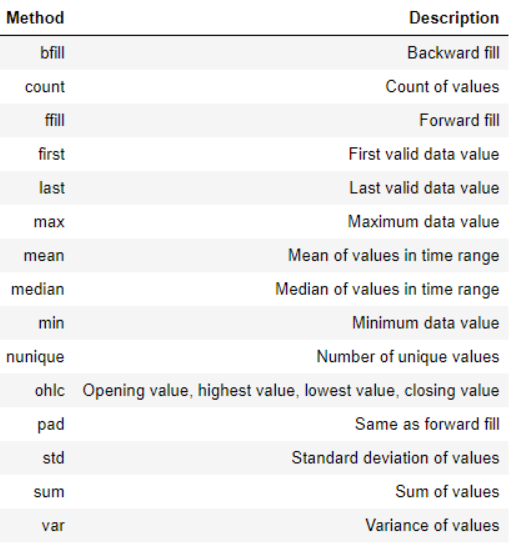

# 다변량 시계열

## 9. 자동 회귀 통합 모델(VAR)
- 여러 시계열 변수로 구성되며 예측에 매우 유용한 도구
- 자동 회귀(AR) 모형의 확장 버전

In [4]:
from statsmodels.tsa.api import VAR

In [6]:
data = sm.datasets.macrodata.load_pandas().data

In [9]:
mydata = data[['realgdp','realdpi']]

In [10]:
mydata.index = data['year']

- adf, kpss 데이터를 통해 정상성 파악

In [13]:
mydata_diff = mydata.diff().dropna()

In [16]:
train = mydata_diff.iloc[:-15,:]
test = mydata_diff.iloc[-15:,:]

- 최적 순서 aic 점수를 바탕으로 선택

In [17]:
forecasting_model = VAR(train)
aic_list = []

for p in range(1,10) :
    results = forecasting_model.fit(p)
    aic_list.append(results.aic)

C:\Users\qhadk\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


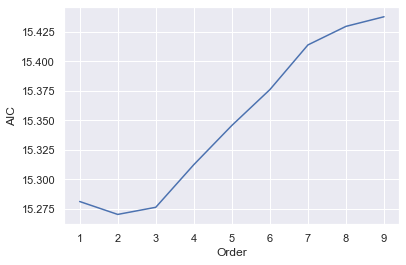

In [18]:
sns.set()
plt.plot(list(np.arange(1,10,1)), aic_list)
plt.xlabel("Order")
plt.ylabel("AIC")
plt.show()

- 가장 낮은 AIC점수는 2이고, 그 이후 p가 커짐에 따라 증가 추세를 보인다. 따라서 VAR모델의 최적 순서는 2로 선택한다.

In [20]:
results = forecasting_model.fit(2)

print(results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 04, Jun, 2021
Time:                     13:01:34
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    15.4445
Nobs:                     185.000    HQIC:                   15.3410
Log likelihood:          -1927.52    FPE:                4.28433e+06
AIC:                      15.2704    Det(Omega_mle):     4.06180e+06
--------------------------------------------------------------------
Results for equation realgdp
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const             21.845566         6.072360            3.598           0.000
L1.realgdp         0.174407         0.078452            2.223           0.026
L1.realdpi         0.250654         0.086862            2.886         

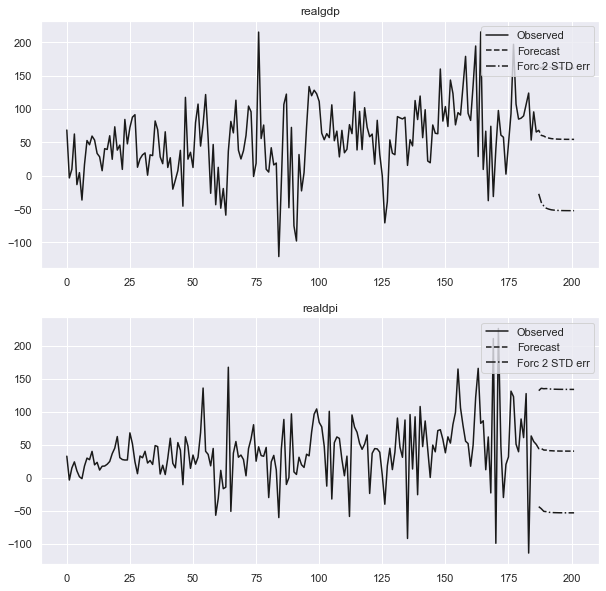

In [23]:
results.plot_forecast(15)
plt.show()

In [25]:
lagged_values = train.values[-results.k_ar:]

In [31]:
forecast = pd.DataFrame(results.forecast(y = lagged_values,steps = 15),index=test.index,columns=test.columns)

- 우리는 차분을 통해 만든 모델이기에 차분을 더하여 예측값으로 만들어야한다

In [41]:
forecast['realgdp_forecasted'] = mydata['realgdp'].iloc[-15-1] + forecast['realgdp'].cumsum()

In [42]:
forecast['realdpi_forecasted'] = mydata['realdpi'].iloc[-15-1] + forecast['realdpi'].cumsum()

In [45]:
test = mydata.iloc[-15:,:]
test["realgdp_forecasted"] = forecast["realgdp_forecasted"]
test["realdpi_forecasted"] = forecast["realdpi_forecasted"]

C:\Users\qhadk\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\qhadk\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


<AxesSubplot:xlabel='year'>

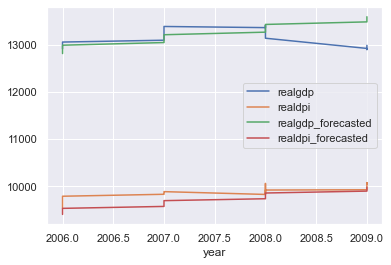

In [46]:
test.plot()

In [56]:
df = pd.read_csv('salesdata2.csv')

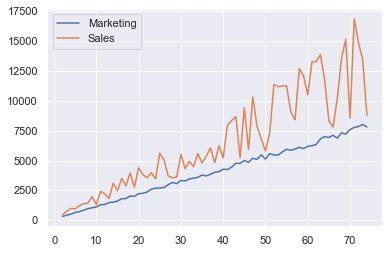

In [89]:
df.iloc[:,2:4].plot()
plt.show()

In [60]:
df.insert(1,'const',1)

In [64]:
model = sm.OLS(endog=df['Sales'],exog=df[['Marketing','const']])

In [65]:
results = model.fit()

In [66]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     403.9
Date:                Fri, 04 Jun 2021   Prob (F-statistic):           1.79e-31
Time:                        13:36:49   Log-Likelihood:                -661.83
No. Observations:                  75   AIC:                             1328.
Df Residuals:                      73   BIC:                             1332.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Marketing      1.7029      0.085     20.096      0.000       1.534       1.872
const       -289.3678    387.756     -0.746      0.458   -1062.165     483.429
==============================================================================
Omnibus:                        2.058   Durbin-Watson:                   1.614
Prob(Omnibus):                  0.357   Jarque-Bera (JB):                1.388
Skew:                          -0.289   Prob(JB):                        0.500
Kurtosis:                       3.331   Cond. No.                     9.22e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.22e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [67]:
df['Sales_diff'] = df['Sales'].diff()
df['Marketing_diff'] = df['Marketing'].diff()

In [68]:
model2 = sm.OLS(endog=df['Sales_diff'].dropna(),exog=df[['Marketing_diff','const']].dropna()).fit()

In [69]:
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:             Sales_diff   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     2.708
Date:                Fri, 04 Jun 2021   Prob (F-statistic):              0.104
Time:                        13:43:22   Log-Likelihood:                -671.02
No. Observations:                  74   AIC:                             1346.
Df Residuals:                      72   BIC:                             1351.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Marketing_diff     2.6104      1.586      1.

In [73]:
print(sm.tsa.stattools.grangercausalitytests(df[['Sales','Marketing']].dropna(),1))


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=33.4561 , p=0.0000  , df_denom=71, df_num=1
ssr based chi2 test:   chi2=34.8698 , p=0.0000  , df=1
likelihood ratio test: chi2=28.5705 , p=0.0000  , df=1
parameter F test:         F=33.4561 , p=0.0000  , df_denom=71, df_num=1
{1: ({'ssr_ftest': (33.45614099594354, 1.810036714936035e-07, 71.0, 1), 'ssr_chi2test': (34.869780756335516, 3.525098908631768e-09, 1), 'lrtest': (28.570467812774496, 9.034970552654862e-08, 1), 'params_ftest': (33.45614099594403, 1.8100367149357332e-07, 71.0, 1.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000001DE9D50B348>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000001DE9D848E08>, array([[0., 1., 0.]])])}


In [72]:
print(sm.tsa.stattools.grangercausalitytests(df[['Marketing','Sales']].dropna(),1))


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3057  , p=0.5821  , df_denom=71, df_num=1
ssr based chi2 test:   chi2=0.3186  , p=0.5724  , df=1
likelihood ratio test: chi2=0.3179  , p=0.5729  , df=1
parameter F test:         F=0.3057  , p=0.5821  , df_denom=71, df_num=1
{1: ({'ssr_ftest': (0.30569245452825977, 0.5820722496889077, 71.0, 1), 'ssr_chi2test': (0.31860903711396094, 0.5724447641510116, 1), 'lrtest': (0.31792510953368947, 0.5728572543076864, 1), 'params_ftest': (0.30569245452806226, 0.58207224968903, 71.0, 1.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000001DE9D3E6048>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000001DE9E1FFC88>, array([[0., 1., 0.]])])}


- p-value를 채택(0.05보다 커야)하여야 인과관계가 없다고 할 수 있으므로 옳은 데이터

In [77]:
df['lag'] = df['Marketing_diff'].shift()
df.dropna(inplace = True)

In [80]:
model3 = sm.tsa.ARIMA(endog=df['Sales'],exog=df['lag'],order = [1,1,0]).fit()
print(model3.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Sales   No. Observations:                   72
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -647.768
Method:                       css-mle   S.D. of innovations           1951.171
Date:                Fri, 04 Jun 2021   AIC                           1303.535
Time:                        13:51:53   BIC                           1312.642
Sample:                             1   HQIC                          1307.161
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           453.9456    266.819      1.701      0.089     -69.010     976.901
lag              -2.9446      1.977     -1.489      0.136      -6.820       0.931
ar.L1.D.Sales    -0.4596      0.113     

C:\Users\qhadk\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\qhadk\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [106]:
train = pd.read_csv('multivariable.csv',parse_dates=['date'],index_col='date')

In [109]:
test = pd.read_csv('multi_test.csv',parse_dates=['date'],index_col='date')

In [121]:
buf = train[(train['item']==1) &(train['store']==1)].copy()

C:\Users\qhadk\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  """Entry point for launching an IPython kernel.


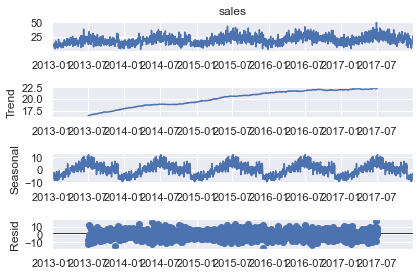

In [127]:
sm.tsa.seasonal_decompose(buf.sales,freq = 365).plot()
plt.show()

- freq = 365 : trend of year.
- freq = 30 : trend of month.
- freq = 7 : trend of week.

In [129]:
tr_start,tr_end = '2014-01-01','2017-09-30'
te_start,te_end = '2017-10-01','2017-12-31'
tra = buf['sales'][tr_start:tr_end].dropna()
tes = buf['sales'][te_start:te_end].dropna()

- ARMA model:(p,q)
- ARIMA model:(p,d,q)
- SARIMA model:(p,d,q)(sp,sd,sq,s)
- ARIMAX model:(p,d,q) + exog
- SARIMAX model:(p,d,q)(sp,sd,sq,s) +exog

- SARIMAX에 seasonal_order = (0,0,0,0)을 활용하면 arimax로 사용 가능

In [131]:
resDiff = sm.tsa.arma_order_select_ic(tra, max_ar=7, max_ma=7, ic='aic', trend='c')
print('ARMA(p,q) =',resDiff['aic_min_order'],'is the best.')

C:\Users\qhadk\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\qhadk\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\qhadk\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\qhadk\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\qhadk\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: invalid value encountered in true_di

ARMA(p,q) = (6, 7) is the best.


- 모델 적합후 잔차로 plot_acf,plot_pacf를 그려 확인한다. 적은 autocorrelation을 보인다면 좋은 모델

In [156]:
buf['month'] = train[(train['item']==1) &(train['store']==1)].reset_index()['date'].dt.month.tolist()

In [160]:
buf = pd.get_dummies(columns=['month'],data=buf)

In [163]:
buf['weekday'] = train[(train['item']==1) &(train['store']==1)].reset_index()['date'].dt.weekday.tolist()

In [166]:
buf = pd.get_dummies(columns=['weekday'],data = buf)

In [169]:
tr_start,tr_end = '2015-01-01','2017-09-30'
te_start,te_end = '2017-10-01','2017-12-31'
tra = buf['sales'][tr_start:tr_end].dropna()
tes = buf['sales'][te_start:te_end].dropna()
exog_train = buf.drop(['store','item','sales'],axis = 1)[tr_start:tr_end].dropna()
exog_test = buf.drop(['store','item','sales'],axis = 1)[te_start:te_end].dropna()

In [172]:
arimax = sm.tsa.statespace.SARIMAX(tra,order=(7,1,7),seasonal_order=(0,0,0,0),exog = exog_train,freq='D',
                                  enforce_stationarity=False, enforce_invertibility=False,).fit()
arimax.summary()

C:\Users\qhadk\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\qhadk\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  sales   No. Observations:                 1004
Model:               SARIMAX(7, 1, 7)   Log Likelihood               -3030.846
Date:                Fri, 04 Jun 2021   AIC                           6129.691
Time:                        14:38:54   BIC                           6296.385
Sample:                    01-01-2015   HQIC                          6193.062
                         - 09-30-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
month_1       -0.0422      1.856     -0.023      0.982      -3.681       3.596
month_2       -0.0339      1.729     -0.020      0.984      -3.422       3.354
month_3       -0.0122      1.527     -0.008      0.994      -3.004       2.980
month_4        0.0589      1.402      0.042      0.967      -2.690       2.807
month_5        0.0038      1.386      0.003      0.998      -2.712       2.719
month_6        0.0483      1.393      0.035      0.972      -2.682       2.779
month_7        0.1010      1.567      0.064      0.949      -2.970       3.172
month_8       -0.0728      1.440     -0.051      0.960      -2.896       2.750
month_9        0.0432      1.473      0.029      0.977      -2.843       2.930
month_10      -0.0586      1.623     -0.036      0.971      -3.239       3.122
month_11       0.1247      1.721      0.072      0.942      -3.249       3.498
month_12      -0.0930      1.782     -0.052      0.958      -3.585       3.399
weekday_0     -0.5456     46.800     -0.012      0.991     -92.271      91.180
weekday_1      0.0283     51.356      0.001      1.000    -100.629     100.685
weekday_2      0.1622     52.560      0.003      0.998    -102.853     103.177
weekday_3     -0.0952     47.508     -0.002      0.998     -93.209      93.018
weekday_4     -0.1345     48.592     -0.003      0.998     -95.372      95.103
weekday_5      0.2164     53.043      0.004      0.997    -103.746     104.179
weekday_6      0.3675     50.107      0.007      0.994     -97.840      98.575
ar.L1         -0.7124      0.234     -3.047      0.002      -1.171      -0.254
ar.L2         -0.6114      0.185     -3.300      0.001      -0.974      -0.248
ar.L3         -0.7746      0.094     -8.206      0.000      -0.960      -0.590
ar.L4         -0.8281      0.170     -4.863      0.000      -1.162      -0.494
ar.L5         -0.6765      0.217     -3.116      0.002      -1.102      -0.251
ar.L6         -0.6008      0.153     -3.937      0.000      -0.900      -0.302
ar.L7          0.0904      0.070      1.290      0.197      -0.047       0.228
ma.L1         -0.1442      0.228     -0.631      0.528      -0.592       0.303
ma.L2         -0.0957      0.125     -0.768      0.442      -0.340       0.148
ma.L3          0.2254      0.131      1.719      0.086      -0.032       0.482
ma.L4          0.2143      0.137      1.560      0.119      -0.055       0.483
ma.L5         -0.0997      0.137     -0.729      0.466      -0.368       0.168
ma.L6         -0.0768      0.119     -0.648      0.517      -0.309       0.156
ma.L7         -0.4557      0.124     -3.662      0.000      -0.700      -0.212
sigma2        25.7841      1.267     20.350      0.000      23.301      28.267
===================================================================================
Ljung-Box (Q):                       56.35   Jarque-Bera (JB):                10.40
Prob(Q):                              0.04   Prob(JB):                         0.01
Heteroskedasticity (H):               0.99   Skew:                

- Ljung-Box의 경우 0.05보다 크므로 시계열 데이터의 잔차는 자기상관이 존재하지 않는다고 할 수 있다.

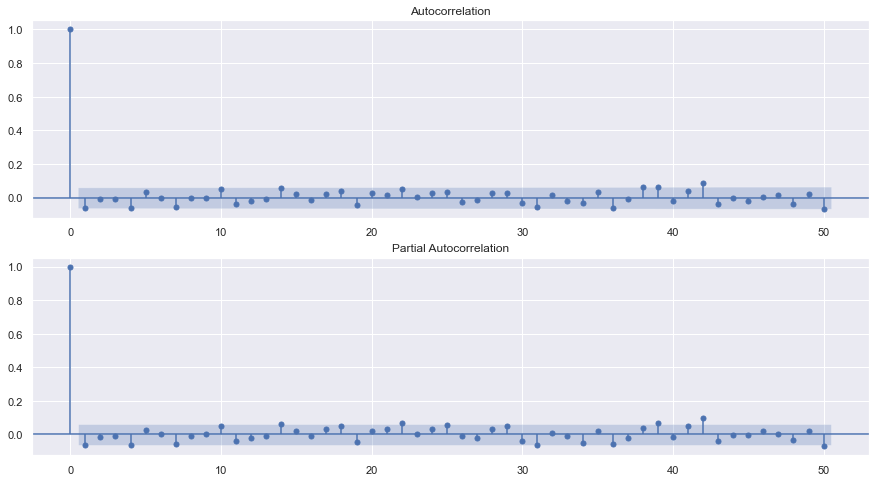

In [173]:
res = arimax.resid
fig,ax = plt.subplots(2,1,figsize = (15,8))
fig = plot_acf(res,lags=50,ax = ax[0])
fig = plot_pacf(res,lags=50,ax = ax[1])
plt.show()

- 잔차의 autocorrelation이 적으므로 좋은 모델이라 할 수 있다.

In [174]:
from sklearn.metrics import mean_squared_error
pred = arimax.predict(tr_end,te_end,exog = exog_test)[1:]
print('ARIMAX model MSE:{}'.format(mean_squared_error(tes,pred)))

ARIMAX model MSE:48.22289550489463


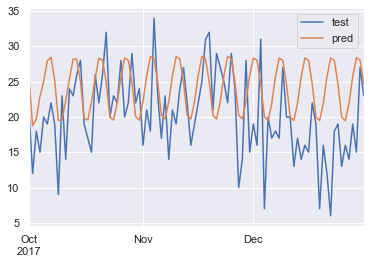

In [175]:
pd.DataFrame({'test':tes,'pred':pred}).plot();plt.show()

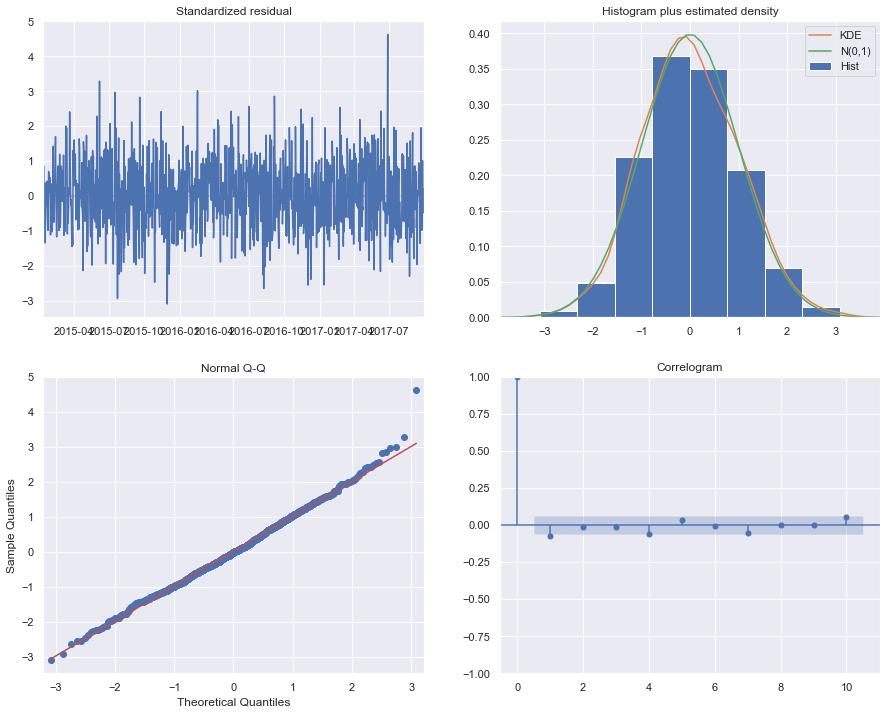

In [177]:
arimax.plot_diagnostics(figsize=(15, 12))
plt.show()

<AxesSubplot:xlabel='date'>

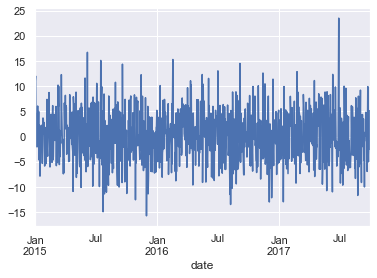

In [186]:
arimax.resid.plot()

In [187]:
res_df = pd.DataFrame(arimax.resid,columns=['resid'])
res_df.sort_values(by='resid',ascending=False).head(5)

,resid
date,
2017-06-28,23.490464
2015-06-06,16.715448
2016-02-17,15.294149
2015-07-16,15.104546
2016-09-05,14.515722


<AxesSubplot:xlabel='date', ylabel='date'>

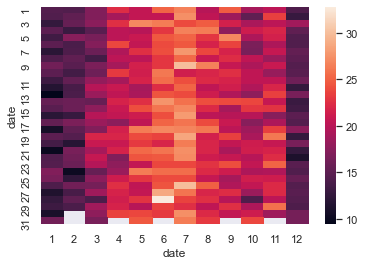

In [191]:
sns.heatmap(buf.pivot_table(values = 'sales',index = buf.index.day,
               columns=buf.index.month,aggfunc='mean'))

In [192]:
buf[(buf.index.day == 28)&(buf.index.month == 6)]['sales']

date
2013-06-28    17
2014-06-28    34
2015-06-28    35
2016-06-28    28
2017-06-28    50
Name: sales, dtype: int64

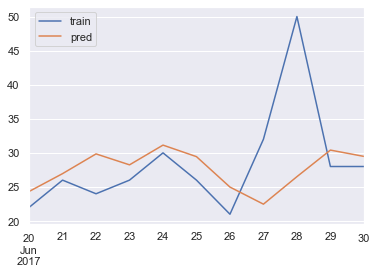

In [193]:
pred = arimax.predict(tr_start,tr_end,exog = exog_train)[1:]
pd.DataFrame({'train':tra['2017-06-20':'2017-06-30'],
              'pred':pred['2017-06-20':'2017-06-30']}).plot();plt.show()

### 진행방법 

- 다변량, 단별량 확인
- 정상성 검증 진행(차분 여부 판단)
- acf,pacf도 그려주기
- 모델링 진행 및 pdq 찾기
- 진행 후 잔차 검증 시행(잔차 이상치 값 확인 후 제거 or 파생변수 생성 후 다시 진행)
- 잔차 검증(sarimax로 시계열 그려주는 것이 사후분석 편리)

계열 데이터의 정상성(Stationarity), 잔차의 이동평균(Moving Average)을 활용한 예측 모델이므로 이러한 Black Swan을 예측하기에는 한계가 분명하다(다른 예측모델도 마찬가지겠지만). 뿐만 아니라 음력을 따르는 휴일, 성장 추세 등을 반영하기에도 어려움이 있을 것이다. 그러나 다른 예측 모델을 활용하기에 앞서 ARIMA가 대략적으로 어떻게 작동하는지를 이해하는 것이 추후에 적절한 모델 선택을 하는데 도움이 될거라 생각한다.

   ARIMA 모델 하나에도 이미 많은 통계적 개념과 함의가 들어있기 때문에 여러가지 구현 사례를 보면서도 이해하기 어려운 부분이 많았다. 특히 파라미터 선택과 튜닝에 대해서는 여러가지 형태의 데이터로 모델링해보면서 ARIMA에 전반에 대한 이해를 끌어올리는 과정이 필요할 것 같다. 